Создадим класс нашего датасета

Необходимые библиотеки

In [1]:
import os
import json
import librosa
import pretty_midi
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

Класс Dataset для подготовки наших данных

In [2]:
import os
import json
import torch
from torch.utils.data import Dataset
import librosa
import librosa.display
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

class PairedAudioChunkDataset(Dataset):
    def __init__(self,
                 json_path,
                 audio_dir,
                 midi_dir,
                 chunk_duration=30.0,
                 sr=22050,
                 bins_per_octave=24,
                 n_octaves=5,
                 overlap_hop_s=0.01,
                 audio_ext='.mp3',
                 max_songs=None):
        """
        Класс датасета, где:
          - спектрограмма CQT сохраняется в дБ,
          - ноты – в формате MIDI (int).
        При построении графика ноты конвертируются в Гц для удобства.

        :param json_path: Путь к JSON-файлу, содержащему соответствия (audio -> midi).
        :param audio_dir: Директория с аудио-файлами.
        :param midi_dir:  Директория с MIDI-файлами.
        :param chunk_duration: Длительность одного чанка (отрезка) в сек.
        :param sr: Частота дискретизации.
        :param bins_per_octave: Кол-во бин/октаву в CQT.
        :param n_octaves: Кол-во октав для CQT.
        :param overlap_hop_s: Сдвиг (hop) в секундах между фреймами CQT.
        :param audio_ext: Расширение аудио-файлов.
        :param max_songs: Максимальное кол-во песен для загрузки (для отладки).
        """
        super().__init__()
        
        self.audio_dir = audio_dir
        self.midi_dir = midi_dir
        self.chunk_duration = chunk_duration
        self.sr = sr
        self.bins_per_octave = bins_per_octave
        self.n_octaves = n_octaves
        self.n_bins = bins_per_octave * n_octaves
        self.overlap_hop_s = overlap_hop_s
        self.audio_ext = audio_ext

        # Считываем JSON с метаданными
        with open(json_path, 'r', encoding='utf-8') as f:
            metadata_list = json.load(f)
        if max_songs is not None:
            metadata_list = metadata_list[:max_songs]

        self.all_chunks = []
        
        for idx, item in enumerate(metadata_list, 1):
            song_name = item.get("song_name")
            midi_name = item.get("midi_vocals")
            
            audio_path = os.path.join(self.audio_dir, song_name + self.audio_ext)
            midi_path = os.path.join(self.midi_dir, midi_name)
            
            # Проверяем существование файлов
            if not os.path.isfile(audio_path):
                print(f"[WARNING] Audio file not found: {audio_path}. Skipping.")
                continue
            if not os.path.isfile(midi_path):
                print(f"[WARNING] MIDI file not found: {midi_path}. Skipping.")
                continue
            
            # Обрабатываем одну песню
            chunks_for_song = self._process_one_song(audio_path, midi_path)
            print(f"{idx}: Processed {song_name}")
            self.all_chunks.extend(chunks_for_song)
        
        print(f"Total chunks of {self.chunk_duration} seconds: {len(self.all_chunks)}")

    def _process_one_song(self, audio_path, midi_path):
        """
        Загружает аудио, считает CQT в dB, режет на чанки по self.chunk_duration.
        Считывает MIDI и для каждого фрейма (в чанке) находит MIDI-ноту (при монофонии) 
        или -1, если нота отсутствует.
        Возвращает список (CQT_db_chunk, MIDI_notes_chunk).
        """
        # 1) Загружаем аудио
        audio_data, sr_actual = librosa.load(audio_path, sr=self.sr)
        
        # 2) Считаем hop_length
        hop_length = int(sr_actual * self.overlap_hop_s)
        
        # 3) Вычисляем CQT
        cqt_complex = librosa.cqt(
            y=audio_data,
            sr=sr_actual,
            fmin=librosa.note_to_hz('C2'),  # минимальная частота
            n_bins=self.n_bins,
            bins_per_octave=self.bins_per_octave,
            hop_length=hop_length
        )
        # Модуль комплексных значений
        cqt_mag = np.abs(cqt_complex)
        # Перевод в dB
        cqt_db = librosa.amplitude_to_db(cqt_mag, ref=np.max)

        total_frames = cqt_db.shape[1]

        # 4) Считываем MIDI
        midi_data = pretty_midi.PrettyMIDI(midi_path)

        # Извлекаем список (start, end, pitch)
        note_events = []
        for instrument in midi_data.instruments:
            if instrument.is_drum:
                continue  # Пропускаем ударные
            for note in instrument.notes:
                # note.pitch (int), note.start (float), note.end (float)
                note_events.append((note.start, note.end, note.pitch))
        # Сортируем по времени старта
        note_events.sort(key=lambda x: x[0])

        # 5) Определяем, сколько фреймов в одном чанке
        chunk_frames = int(np.floor(self.chunk_duration * sr_actual / hop_length))
        
        # 6) Сколько "полных" чанков
        num_chunks = total_frames // chunk_frames
        chunks_list = []
        
        for i in range(num_chunks):
            start_frame = i * chunk_frames
            end_frame = (i + 1) * chunk_frames
            
            # Спектрограмма в dB для текущего чанка
            cqt_db_chunk = cqt_db[:, start_frame:end_frame]  # (n_bins, chunk_frames)
            
            # Подготовим массив MIDI-нот
            midi_note_array = np.full((chunk_frames,), -1, dtype=np.int32)  
            # -1 => нет ноты
            
            for frame_idx in range(chunk_frames):
                real_frame = start_frame + frame_idx
                # Секунда в аудио
                t_sec = real_frame * (hop_length / sr_actual)
                active_notes = self._get_active_notes_at_time(t_sec, note_events)
                
                if active_notes:
                    # Берем первую активную ноту (монофония)
                    midi_note_array[frame_idx] = active_notes[0]
            
            # Превращаем в тензоры
            cqt_db_tensor = torch.tensor(cqt_db_chunk, dtype=torch.float32)
            midi_tensor = torch.tensor(midi_note_array, dtype=torch.int64)
            
            chunks_list.append((cqt_db_tensor, midi_tensor))
        
        return chunks_list

    def _get_active_notes_at_time(self, t_sec, note_events):
        """
        Возвращает список MIDI-нот, которые звучат в момент времени t_sec.
        Если несколько нот, возвращаем все — дальше решаем, какую использовать.
        """
        active = []
        for (start, end, pitch_midi) in note_events:
            if start <= t_sec < end:
                active.append(pitch_midi)
        return active

    def __len__(self):
        return len(self.all_chunks)

    def __getitem__(self, idx):
        """
        Возвращает (cqt_db_tensor, midi_note_tensor), где:
         - cqt_db_tensor.shape = (n_bins, chunk_frames)
         - midi_note_tensor.shape = (chunk_frames,)
        """
        return self.all_chunks[idx]

    def plot_sample_with_labels(self, idx):
        """
        Строит график CQT (в dB) + MIDI ноты (конвертируем их в Гц при отрисовке).
        """
        if idx < 0 or idx >= len(self):
            print(f"Index {idx} is out of range.")
            return
        
        cqt_db_tensor, midi_tensor = self[idx]
        
        # Преобразуем в NumPy
        cqt_db = cqt_db_tensor.numpy()
        midi_notes = midi_tensor.numpy()
        
        # Размеры данных
        n_bins, chunk_frames = cqt_db.shape
        
        # Готовим временную ось (от 0 до chunk_duration)
        time_axis = np.linspace(0, self.chunk_duration, num=chunk_frames)
        
        # Для отображения спектрограммы укажем fmin
        fmin = librosa.note_to_hz('C2')
        
        # Частоты каждого CQT-бина (для y-оси)
        freqs_cqt = librosa.cqt_frequencies(
            n_bins=self.n_bins,
            fmin=fmin,
            bins_per_octave=self.bins_per_octave
        )
        
        # Рисуем CQT в dB
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(
            cqt_db,
            sr=self.sr,
            hop_length=int(self.sr * self.overlap_hop_s),
            x_axis='time',
            y_axis='cqt_hz',
            fmin=fmin
        )
        plt.colorbar(format="%+2.0f dB")
        plt.title("CQT (dB) + MIDI Notes (converted to Hz)")
        
        # Теперь наложим MIDI-ноты
        # Для каждого фрейма, если midi_notes[i] != -1, конвертируем в частоту
        scatter_times = []
        scatter_freqs = []
        
        for i_frame in range(chunk_frames):
            midi_note = midi_notes[i_frame]
            if midi_note >= 0:  # Есть активная нота
                scatter_times.append(time_axis[i_frame])
                freq_hz = pretty_midi.note_number_to_hz(midi_note)
                scatter_freqs.append(freq_hz)
        
        if len(scatter_times) > 0:
            plt.scatter(
                scatter_times, scatter_freqs,
                color='red', s=15, alpha=0.7, label='MIDI Note (Hz)'
            )
        
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()


Создаем dataset

In [3]:
if __name__ == "__main__":
    # 1) Инициализируем датасет
    json_path = "data/pairs.json"
    audio_dir = "data/audi_vocals"
    midi_dir  = "data/midi_vocals"

dataset = PairedAudioChunkDataset(
    json_path=json_path,
    audio_dir=audio_dir,
    midi_dir=midi_dir,
    chunk_duration=30.0,
    sr=22050,
    bins_per_octave=24,
    n_octaves=5,
    overlap_hop_s=0.01,
    audio_ext='.mp3',
    max_songs=15  # Установите в None, чтобы обработать все песни
)

1: Processed Back In Black_vocals
2: Processed Creeping Death_vocals
3: Processed Everlong_vocals
4: Processed Californication_vocals
5: Processed Ride The Lightning_vocals
6: Processed Iron Man_vocals
7: Processed Psychosocial_vocals
8: Processed Symphony Of Destruction_vocals
9: Processed Can't Stop_vocals
10: Processed November Rain_vocals
11: Processed Zombie_vocals
12: Processed Blackened_vocals
13: Processed War Pigs_vocals
14: Processed Heart Shaped Box_vocals
15: Processed Hail To The King_vocals
Total chunks of 30.0 seconds: 164


Создаем батч

In [4]:
def chunk_collate_fn(batch):
    """
    Пакует список из (cqt_tensor, pitch_tensor) в батч.
    """
    cqt_list, pitch_list = [], []
    for (cqt, pitch) in batch:
        # Добавим измерение канала (in_channels=1) для последующей передачи в CNN
        cqt_list.append(cqt.unsqueeze(0))   # (1, n_bins, chunk_frames)
        pitch_list.append(pitch)           # (chunk_frames,)

    # Сконкатенируем по batch
    cqt_batch   = torch.stack(cqt_list, dim=0)   # (batch, 1, n_bins, chunk_frames)
    pitch_batch = torch.stack(pitch_list, dim=0) # (batch, chunk_frames)

    return cqt_batch, pitch_batch

Создаем класс нейронки

In [5]:
class DeepCNNFor30sec(nn.Module):
    def __init__(self, num_classes=129):
        super().__init__()
        # Каждый блок:
        #  (Conv2D) -> (BatchNorm2d) -> (ReLU) -> (MaxPool2d или strided conv)
        # Блок 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Блок 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        # Блок 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        # Блок 4 — выводим на num_classes каналов, 
        # чтобы можно было интерпретировать их как логиты классов.
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1)

        # Вместо pooling по временной оси мы хотим «сохранить» разрешение по времени,
        # чтобы в итоге иметь (batch, num_classes, frames).
        # А вот по частотной оси (n_bins) можем за пару пулингов уменьшить размер.
        # Например, после каждого блока делаем MaxPool только по оси частот (kernel=2 по высоте),
        # а по времени (ось W) не трогаем.
        self.pool_freq = nn.MaxPool2d(kernel_size=(2,1))  # pool только по высоте
        
        # Запомним, что после ~2 пулингов высота n_bins сократится в 4 раза (2*2).
        # Если n_bins = 120 (5 октав * 24), то станет 30. И так далее.
        
        # fin_conv -> (batch, num_classes, reduced_bins, frames)
        # Потом сделаем адаптивный pooling (global pooling) по частоте,
        # чтобы прийти к (batch, num_classes, 1, frames) -> squeeze -> (batch, num_classes, frames).
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, None))  # (целим высоту в 1, ширину не трогаем)

    def forward(self, x):
        """
        x: (batch, 1, n_bins, chunk_frames)
        Выход: (batch, num_classes, chunk_frames)
        """
        # Блок 1
        x = F.relu(self.bn1(self.conv1(x)))  # (batch, 32, n_bins, frames)
        x = self.pool_freq(x)               # (batch, 32, n_bins/2, frames)

        # Блок 2
        x = F.relu(self.bn2(self.conv2(x))) # (batch, 64, n_bins/2, frames)
        x = self.pool_freq(x)               # (batch, 64, n_bins/4, frames)

        # Блок 3
        x = F.relu(self.bn3(self.conv3(x))) # (batch, 128, n_bins/4, frames)
        # Можно ещё раз pool, если хотим еще уменьить частотную ось (по желанию):
        # x = self.pool_freq(x)             # (batch, 128, n_bins/8, frames)

        # Блок 4 (выходной)
        x = self.conv4(x)                   # (batch, num_classes, n_bins/4, frames)

        # Глобальный pooling по частоте (высоте)
        x = self.global_pool(x)             # (batch, num_classes, 1, frames)
        x = x.squeeze(2)                    # (batch, num_classes, frames)
        return x

In [14]:
from torch.utils.data import random_split
# ----------------- ФУНКЦИЯ ДЛЯ МАППИНГА -1 -> 128 ----------------- #
def encode_label(label: int) -> int:
    """
    Превращаем 'MIDI pitch' или -1 в диапазон [0..128].
    -1 -> 128 (класс "нет ноты")
    [0..127] -> без изменений
    """
    if label == -1:
        return 128
    else:
        return label

# ------------------ ПРИМЕР ИСПОЛЬЗОВАНИЯ ------------------ #
if __name__ == "__main__":
    # 2) Разделим на train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # 3) DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=5,           # т.к. чанки большие, можно взять небольшой batch_size
        shuffle=True,
        collate_fn=chunk_collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=5,
        shuffle=False,
        collate_fn=chunk_collate_fn
    )

    # 4) Модель, оптимизатор, лосс
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepCNNFor30sec(num_classes=129).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()  # будет работать по оси (num_classes), на каждом фрейме
    # 5) Функция для покадрового accuracy
    def calculate_accuracy_framewise(y_pred, y_true):
        """
        y_pred: (batch, num_classes, frames)
        y_true: (batch, frames)
        """
        # Аргмакс по оси classes -> (batch, frames)
        preds = torch.argmax(y_pred, dim=1)  # (batch, frames)
        correct = (preds == y_true).sum().item()
        total = y_true.numel()  # общее количество фреймов во всех батчах
        return correct / total
    num_epochs = 20
    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for cqt_batch, pitch_batch in train_loader:
            # Превращаем -1 в 128
            pitch_batch_encoded = []
            for seq in pitch_batch:
                seq_encoded = [encode_label(int(p)) for p in seq]
                pitch_batch_encoded.append(torch.tensor(seq_encoded, dtype=torch.long))
            pitch_batch_encoded = torch.stack(pitch_batch_encoded, dim=0)  # (batch, chunk_frames)
            cqt_batch = cqt_batch.to(device)
            pitch_batch_encoded = pitch_batch_encoded.to(device)
            optimizer.zero_grad()
            outputs = model(cqt_batch)  # (batch, num_classes, frames)
            # Для CrossEntropyLoss у нас формат (N, C, ...) vs (N, ...),
            # здесь: (batch, num_classes, frames) vs (batch, frames).
            loss = criterion(outputs, pitch_batch_encoded)
            loss.backward()
            optimizer.step()
            # Accuracy (покадровая)
            acc = calculate_accuracy_framewise(outputs, pitch_batch_encoded)
            running_loss += loss.item()
            running_acc += acc
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = running_acc / len(train_loader)
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for cqt_batch, pitch_batch in val_loader:
                pitch_batch_encoded = []
                for seq in pitch_batch:
                    seq_encoded = [encode_label(int(p)) for p in seq]
                    pitch_batch_encoded.append(torch.tensor(seq_encoded, dtype=torch.long))
                pitch_batch_encoded = torch.stack(pitch_batch_encoded, dim=0)

                cqt_batch = cqt_batch.to(device)
                pitch_batch_encoded = pitch_batch_encoded.to(device)

                outputs = model(cqt_batch)
                loss = criterion(outputs, pitch_batch_encoded)

                acc = calculate_accuracy_framewise(outputs, pitch_batch_encoded)
                val_loss += loss.item()
                val_acc += acc

        epoch_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_val_acc  = val_acc / len(val_loader) if len(val_loader) > 0 else 0

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    print("Обучение завершено!")


Epoch [1/20] Train Loss: 2.1407, Train Acc: 0.5661 | Val Loss: 1.5109, Val Acc: 0.6609
Epoch [2/20] Train Loss: 1.6542, Train Acc: 0.6154 | Val Loss: 1.5757, Val Acc: 0.6606
Epoch [3/20] Train Loss: 1.6512, Train Acc: 0.6133 | Val Loss: 1.8247, Val Acc: 0.6609
Epoch [4/20] Train Loss: 1.7725, Train Acc: 0.5937 | Val Loss: 1.5995, Val Acc: 0.6606
Epoch [5/20] Train Loss: 1.6260, Train Acc: 0.6145 | Val Loss: 1.4994, Val Acc: 0.6608
Epoch [6/20] Train Loss: 1.6346, Train Acc: 0.6139 | Val Loss: 1.5003, Val Acc: 0.6537
Epoch [7/20] Train Loss: 1.6631, Train Acc: 0.5959 | Val Loss: 1.4938, Val Acc: 0.6606
Epoch [8/20] Train Loss: 1.7640, Train Acc: 0.5910 | Val Loss: 1.4791, Val Acc: 0.6610
Epoch [9/20] Train Loss: 1.6976, Train Acc: 0.5906 | Val Loss: 1.4589, Val Acc: 0.6598
Epoch [10/20] Train Loss: 1.6196, Train Acc: 0.6142 | Val Loss: 1.6853, Val Acc: 0.6589
Epoch [11/20] Train Loss: 1.5997, Train Acc: 0.6128 | Val Loss: 1.4523, Val Acc: 0.6601
Epoch [12/20] Train Loss: 1.5968, Train A

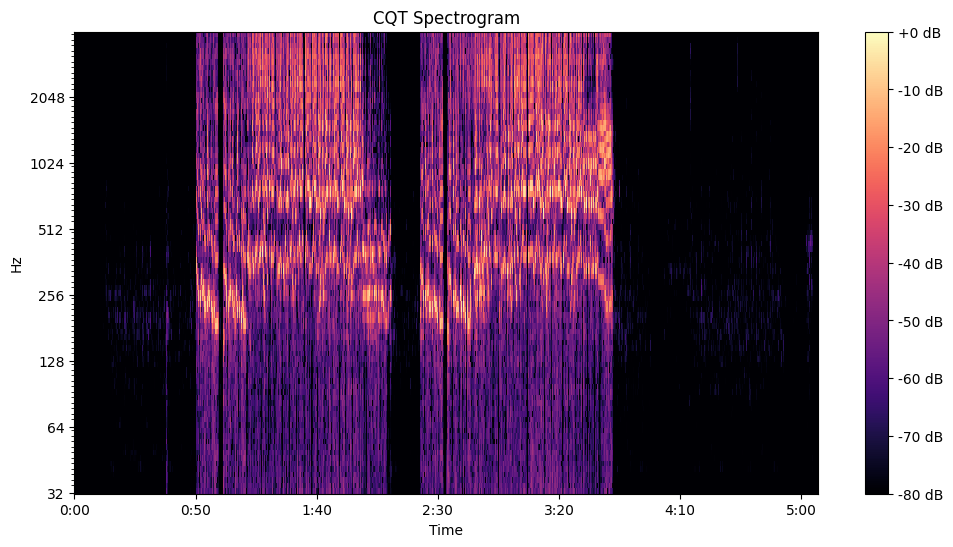

In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Загрузить аудио файл (вы можете указать свой путь к файлу)
audio_file = 'data/audi_vocals/Zombie_vocals.mp3'
y, sr = librosa.load(audio_file, sr=None)  # sr=None, чтобы сохранить оригинальную частоту дискретизации

# Преобразование в CQT спектрограмму
cqt = librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1'), n_bins=84, bins_per_octave=12)

# Преобразуем в дБ (децибелы) для лучшей визуализации
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

# Визуализируем CQT спектрограмму
plt.figure(figsize=(12, 6))
librosa.display.specshow(cqt_db, x_axis='time', y_axis='cqt_hz', hop_length=512, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title("CQT Spectrogram")
plt.show()


In [30]:
dataset[10]

(tensor([[-64.0085, -65.8799, -68.2462,  ..., -80.0000, -80.0000, -80.0000],
         [-61.1504, -61.8975, -62.6699,  ..., -80.0000, -80.0000, -80.0000],
         [-64.1579, -63.7983, -63.5133,  ..., -80.0000, -80.0000, -80.0000],
         ...,
         [-44.4747, -43.3362, -36.3298,  ..., -80.0000, -80.0000, -80.0000],
         [-45.1253, -33.5014, -29.7338,  ..., -78.1981, -77.9638, -80.0000],
         [-43.1067, -31.3623, -29.8643,  ..., -78.8392, -79.2285, -80.0000]]),
 tensor([64, 64, 64,  ..., -1, -1, -1]))

In [49]:
# Обрезаем аудио до первых 30 секунд (если нужно)
max_duration = 30  # Максимальная длительность в секундах
y = y[:int(max_duration * sr)]

# Пересчитываем CQT для обрезанного аудио
cqt = librosa.cqt(y, sr=22050, n_bins=24*5, bins_per_octave=24, fmin=librosa.note_to_hz('C2') ,hop_length=int(22050 * 0.01))
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

# Преобразуем в формат, который ожидает модель (batch_size, n_channels, time_steps, freq_bins)
cqt_db = np.expand_dims(cqt_db, axis=0)  # Добавляем размерность для batch_size
cqt_db = np.expand_dims(cqt_db, axis=1)  # Добавляем размерность для каналов (моно)

# Преобразуем в tensor для подачи в модель
import torch
cqt_tensor = torch.tensor(cqt_db, dtype=torch.float32)


In [50]:
cqt_tensor.shape

torch.Size([1, 1, 120, 6014])

In [51]:
# Загрузка модели
model = DeepCNNFor30sec(num_classes=129)  # Замените на вашу модель
model.eval()  # Переводим модель в режим инференса

# Прогоняем аудио через модель
with torch.no_grad():
    output = model(cqt_tensor)

# Применяем softmax для получения вероятностей (если нужно)
probabilities = torch.softmax(output, dim=1)  # (batch_size, num_classes, time_steps)


In [52]:
probabilities.shape

torch.Size([1, 129, 6014])

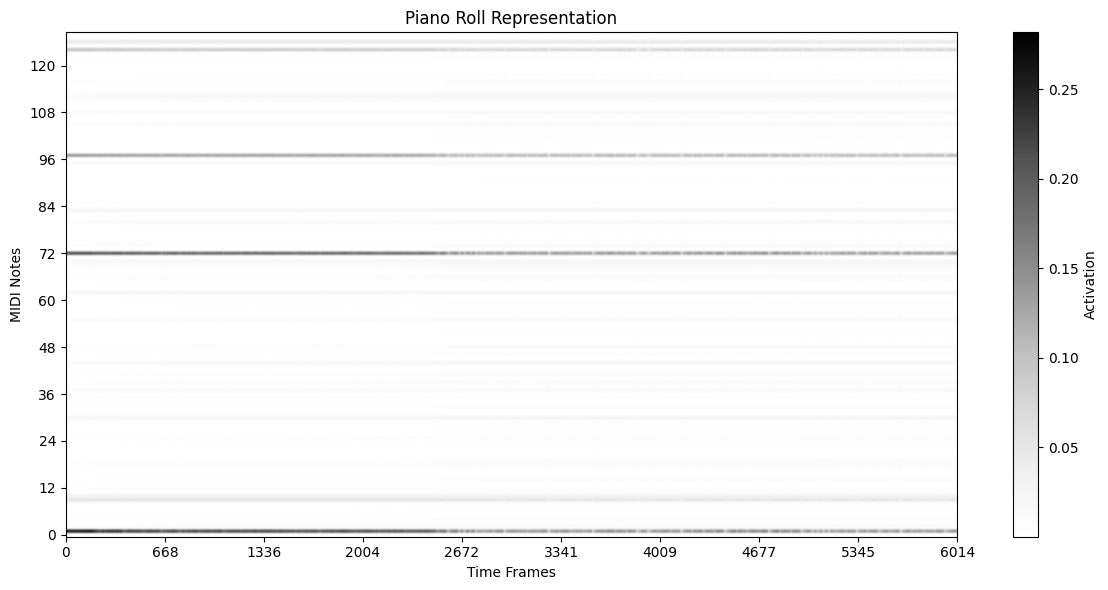

In [53]:
# 1. Преобразуем тензор в NumPy
output_numpy = probabilities.squeeze(0).cpu().detach().numpy()  # Убираем размерность batch

# 2. Построение пианоролла
plt.figure(figsize=(12, 6))
plt.imshow(output_numpy, aspect='auto', origin='lower', cmap='Greys')
plt.colorbar(label="Activation")
plt.title("Piano Roll Representation")
plt.xlabel("Time Frames")
plt.ylabel("MIDI Notes")

# Настраиваем оси
plt.xticks(np.linspace(0, output_numpy.shape[1], num=10), labels=np.linspace(0, output_numpy.shape[1], num=10, dtype=int))
plt.yticks(np.arange(0, 129, 12), labels=np.arange(0, 129, 12))  # Каждая 12-я нота (октавы)

plt.tight_layout()
plt.show()